In [34]:
import numpy as np
import os
from os import path as op
import string
import re
from subprocess import Popen
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import netCDF4

from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import cartopy
import sys
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm

from skimage import io

DATAPATH= '/scratch/adomakor412/april_data_2019/'
%matplotlib inline

In [35]:
G16 = xr.open_dataset(op.join(DATAPATH,
                              'OR_ABI-L1b-RadF-M6C07_G16_s20191030000200_e20191030009519_c20191030009557.nc'))
G17 = xr.open_dataset(op.join(DATAPATH,
                              'OR_ABI-L1b-RadF-M6C07_G17_s20191030000339_e20191030009417_c20191030009441.nc'))

In [36]:
g16_band7 = G16['Rad']
g17_band7 = G17['Rad']

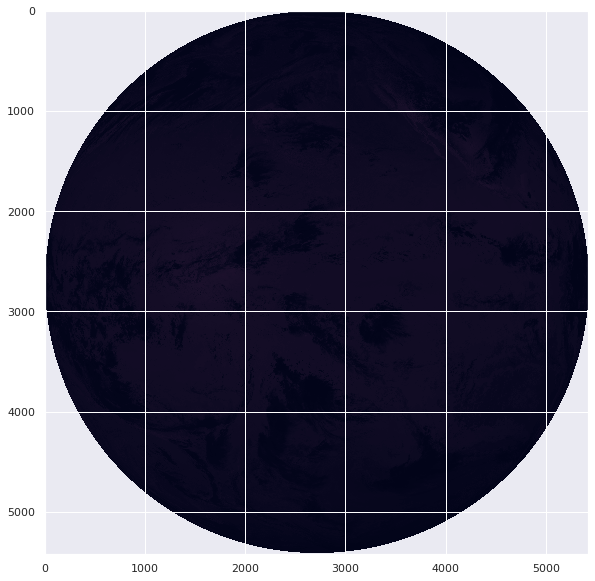

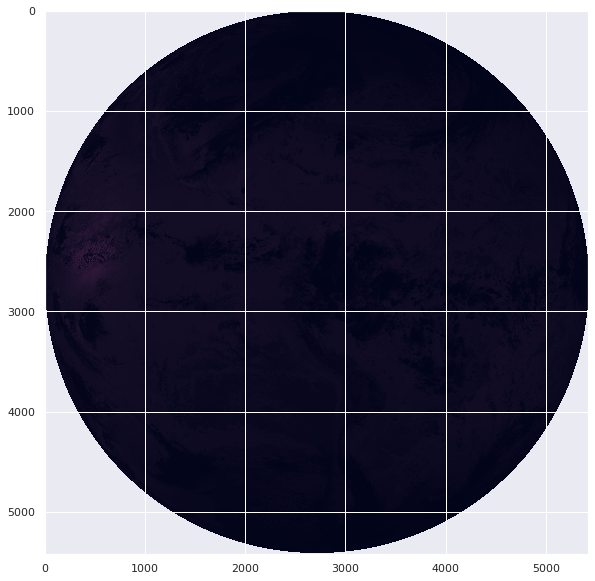

In [37]:
fig_1, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.imshow(g17_band7)
fig_1, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.imshow(g16_band7)

In [38]:
dat16 = G16.metpy.parse_cf('Rad')
dat17 = G17.metpy.parse_cf('Rad')


In [39]:
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs

In [40]:
x16= dat16.x
y16 = dat16.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes16 = (x16.min(), x16.max(), y16.min(), y16.max())
pyresample_extent_goes16 = [float(x16.min()), float(y16.min()), float(x16.max()), float(y16.max())]


x17 = dat17.x
y17 = dat17.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes17 = (x17.min(), x17.max(), y17.min(), y17.max())
pyresample_extent_goes17 = [float(x17.min()), float(y17.min()), float(x17.max()), float(y17.max())]

Text(0.5, 1.0, 'GOES-17')

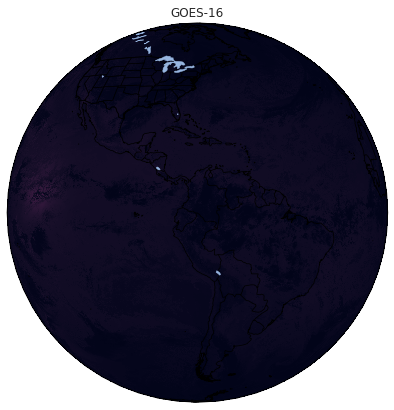

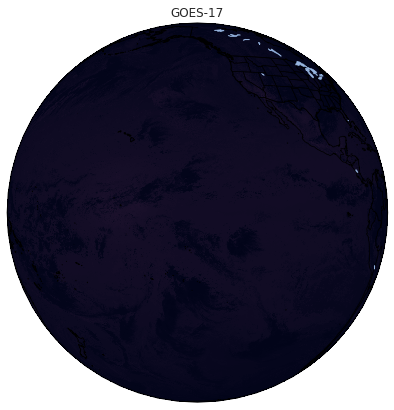

In [41]:
fig_2 = plt.figure(figsize=(15, 8))

ax1_2 = fig_2.add_subplot(1, 2, 1, projection=geos16)


## GOES 16
ax1_2.imshow(g16_band7, origin='upper', extent=cartopy_extent_goes16,
           transform=geos16)
ax1_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax1_2.set_title('GOES-16')

#-----
fig_2 = plt.figure(figsize=(15, 8))

ax2_2 = fig_2.add_subplot(1, 2, 2, projection=geos17)


## GOES 17
ax2_2.imshow(g17_band7, origin='upper', extent=cartopy_extent_goes17,
           transform=geos17)
ax2_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax2_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax2_2.set_title('GOES-17')
#

In [42]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

big_box_extent_pc_cartopy = [-116, -95, -10, 10]
big_box_extent_mc = mc.transform_points(pc, 
                    np.array(big_box_extent_pc_cartopy[:2]),
                    np.array(big_box_extent_pc_cartopy[2:])).ravel()
big_box_extent_mc_cartopy = [
    big_box_extent_mc[0],
    big_box_extent_mc[3],
    big_box_extent_mc[1],
    big_box_extent_mc[4]
]
roi_extent_pc_cartopy = [-109.59326, -102.40674, 
                          8.94659, -8.94656]
roi_extent_mc = mc.transform_points(pc, 
                    np.array(roi_extent_pc_cartopy[:2]),
                    np.array(roi_extent_pc_cartopy[2:])).ravel()
roi_extent_mc_cartopy = [
    roi_extent_mc[0],
    roi_extent_mc[3],
    roi_extent_mc[1],
    roi_extent_mc[4]
]
roi_extent_mc_pyresample = [
    roi_extent_mc[0],
    roi_extent_mc[1],
    roi_extent_mc[3],
    roi_extent_mc[4]
]
print(big_box_extent_mc_cartopy)
print(roi_extent_mc_cartopy)

[-12913060.932019735, -10575351.62536099, -1111475.102852225, 1111475.1028522244]
[-12199865.897574836, -11399866.150599161, 993361.388724224, -993358.0300969948]


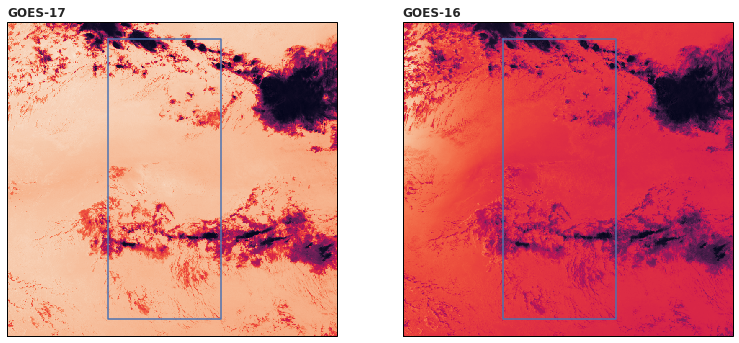

In [66]:

#-----
fig_3 = plt.figure(figsize=(13, 8))

ax_3 = fig_3.add_subplot(1, 2, 1, projection=mc)

ax_3.set_extent(big_box_extent_mc_cartopy, crs=mc)

ax_4 = fig_3.add_subplot(1, 2, 2, projection=mc)

ax_4.set_extent(big_box_extent_mc_cartopy, crs=mc)

roi_x = [roi_extent_mc_cartopy[0], 
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[0],
         roi_extent_mc_cartopy[0]]

roi_y = [roi_extent_mc_cartopy[2], 
         roi_extent_mc_cartopy[2],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[2]]

# GOES16
img4 = ax_4.imshow(g16_band7, origin='upper',
           extent=cartopy_extent_goes16,
           transform=geos16,
           interpolation='none')
ax_4.add_feature(ccrs.cartopy.feature.STATES)
ax_4.coastlines(resolution='50m', color='black', linewidth=.75)
ax_4.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_4.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_4.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_4.set_title('GOES-16', loc='left', fontweight='bold')
ax_4.plot(roi_x, roi_y,'b-')

# GOES17
img3 = ax_3.imshow(g17_band7, origin='upper',
           extent=cartopy_extent_goes17,
           transform=geos17,
           interpolation='none')
ax_3.add_feature(ccrs.cartopy.feature.STATES)
ax_3.coastlines(resolution='50m', color='black', linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_3.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_3.set_title('GOES-17', loc='left', fontweight='bold')
ax_3.plot(roi_x, roi_y,'b-')
#fig_3.colorbar(img4)

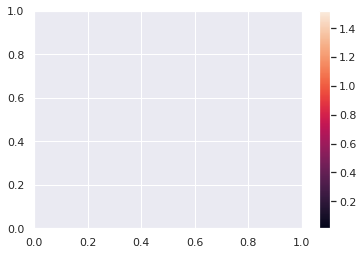

In [68]:
plt.colorbar(img4)

In [48]:
DATAPATH= '/scratch/adomakor412/all_npy3/'
np16 = np.load(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G16_s20191030000200_e20191030009519_c20191030009557.npy'))
np17 = np.load(op.join(DATAPATH,'OR_ABI-L1b-RadF-M6C07_G17_s20191030000339_e20191030009417_c20191030009441.npy'))

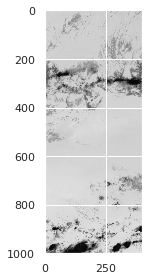

In [61]:
io.imshow(np17)

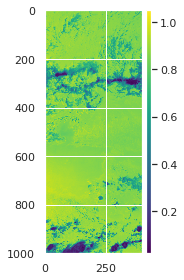

In [62]:
io.imshow(np16)

ValueError: x and y must have same first dimension, but have shapes (1001, 401) and (5,)

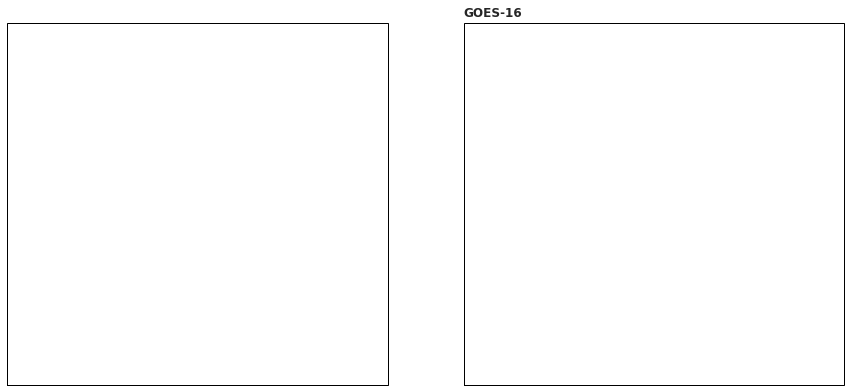

In [57]:
fig_4 = plt.figure(figsize=(15, 8))

ax_5 = fig_4.add_subplot(1, 2, 1, projection=mc)

ax_5.set_extent(big_box_extent_mc_cartopy, crs=mc)

ax_6 = fig_4.add_subplot(1, 2, 2, projection=mc)

ax_6.set_extent(big_box_extent_mc_cartopy, crs=mc)

ax_6.set_title('GOES-16', loc='left', fontweight='bold')
ax_6.plot(np16, roi_y,'b-')

ax_5.set_title('GOES-17', loc='left', fontweight='bold')
ax_5.plot(np17, roi_y,'b-')